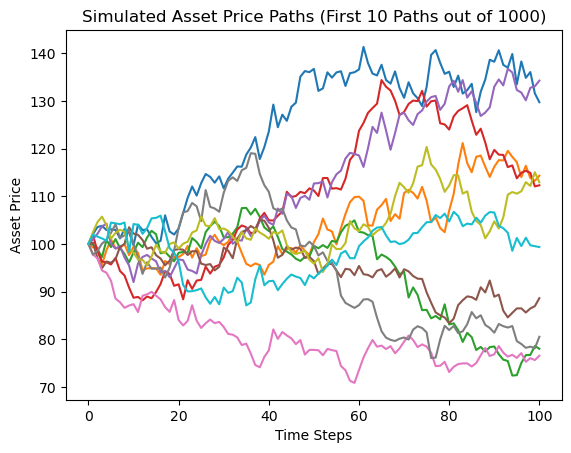

maturity prices of first 10 paths
[129.71425011 114.30532558  78.00884507 112.29674154 134.2372633
  88.62107538  76.54890904  80.52863274 112.93269639  99.34080952]
Call option payoffs for first 10 paths
[24.71425011  9.30532558  0.          7.29674154 29.2372633   0.
  0.          0.          7.93269639  0.        ]
Put option payoffs for first 10 paths
[ 0.          0.         26.99115493  0.          0.         16.37892462
 28.45109096 24.47136726  0.          5.65919048]
First 10 Call Option Prices:
[10.47918973  6.75331928 10.53818206  8.00544151  8.54847903  7.75960132
  0.         10.81288716 11.13810926 10.69746847]
First 10 Put Option Prices:
[ 5.26759387 11.38771041 31.10663251 16.73470519 12.93394364 20.7627774
 33.15835321 27.85711656 10.61835393 17.5818755 ]
American call and put option prices, averaged across all price paths
8.208434076775193 16.511849738540047


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Simulate GBM Paths
def simulate_gbm_paths(S0, mu, sigma, T, dt, num_paths):
    """
    Simulate asset price paths using Geometric Brownian Motion (GBM).
    
    Parameters:
        S0: float - Initial asset price
        mu: float - Drift (expected return)
        sigma: float - Volatility
        T: float - Time to maturity (in years)
        dt: float - Time step
        num_paths: int - Number of paths to simulate
        
    Returns:
        np.ndarray - Simulated asset price paths (num_steps x num_paths)
    """
    num_steps = int(T / dt) + 1  # Total time steps
    paths = np.zeros((num_steps, num_paths))  # Initialize matrix for price paths
    paths[0] = S0  # Set initial price for all paths

    # Simulate paths
    for t in range(1, num_steps):
        Z = np.random.normal(0, 1, num_paths)  # Random noise for each path
        paths[t] = paths[t - 1] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        )
    
    return paths

# Parameters
S0 = 100  # Initial price
mu = 0.05  # Drift
sigma = 0.2  # Volatility
T = 1  # Maturity (1 year)
dt = 0.01  # Time step
num_paths = 1000w  # Number of paths

# Simulate GBM paths for 1000 simulations
paths = simulate_gbm_paths(S0, mu, sigma, T, dt, num_paths)

# Plot only the first 10 simulated paths
plt.plot(paths[:, :10])
plt.title("Simulated Asset Price Paths (First 10 Paths out of 1000)")
plt.xlabel("Time Steps")
plt.ylabel("Asset Price")
plt.show()

# Print the stock prices at maturity for the first 10 paths
maturity_prices_first_10 = paths[-1, :10]
print("maturity prices of first 10 paths")
print(maturity_prices_first_10)

# Step 2: Compute Payoffs for Call and Put Options
def compute_call_payoff(paths, K):
    """
    Compute the payoff for a call option at maturity for each simulated path.
    
    Parameters:
        paths: np.ndarray - Simulated asset price paths (num_steps x num_paths)
        K: float - Strike price
        
    Returns:
        np.ndarray - Payoff at maturity for each path
    """
    S_T = paths[-1]  # Stock prices at maturity (last row of the paths array)
    return np.maximum(S_T - K, 0)  # Call payoff: max(S_T - K, 0)

def compute_put_payoff(paths, K):
    """
    Compute the payoff for a put option at maturity for each simulated path.
    
    Parameters:
        paths: np.ndarray - Simulated asset price paths (num_steps x num_paths)
        K: float - Strike price
        
    Returns:
        np.ndarray - Payoff at maturity for each path
    """
    S_T = paths[-1]  # Stock prices at maturity (last row of the paths array)
    return np.maximum(K - S_T, 0)  # Put payoff: max(K - S_T, 0)

# Strike price
K = 105  # Strike price

# Compute payoffs
call_payoffs = compute_call_payoff(paths, K)
put_payoffs = compute_put_payoff(paths, K)

# Print the first 10 payoffs for call and put options
print("Call option payoffs for first 10 paths")
print(call_payoffs[:10])

print("Put option payoffs for first 10 paths")
print(put_payoffs[:10])

from sklearn.linear_model import LinearRegression

# Step 3: Backward Induction for Call and Put Options
def backward_induction_call(paths, K, r, dt):
    """
    Perform backward induction to compute the American call option price.
    
    Parameters:
        paths: np.ndarray - Simulated asset price paths (num_steps x num_paths)
        K: float - Strike price
        r: float - Risk-free rate
        dt: float - Time step
        
    Returns:
        np.ndarray - Option prices for each path
    """
    num_steps, num_paths = paths.shape
    cash_flows = np.maximum(paths[-1] - K, 0)  # Payoffs at maturity (last step)
    for t in range(num_steps - 2, 0, -1):  # Work backward from second-to-last step
        in_the_money = paths[t] > K  # Identify in-the-money paths
        if np.any(in_the_money):
            X = paths[t, in_the_money].reshape(-1, 1)
            Y = cash_flows[in_the_money] * np.exp(-r * dt)
            regression = LinearRegression().fit(X, Y)
            continuation_values = regression.predict(X)
            exercise_values = paths[t, in_the_money] - K
            cash_flows[in_the_money] = np.maximum(continuation_values, exercise_values)
        cash_flows *= np.exp(-r * dt)  # Discount to previous time step
    return cash_flows

def backward_induction_put(paths, K, r, dt):
    """
    Perform backward induction to compute the American put option price.
    
    Parameters:
        paths: np.ndarray - Simulated asset price paths (num_steps x num_paths)
        K: float - Strike price
        r: float - Risk-free rate
        dt: float - Time step
        
    Returns:
        np.ndarray - Option prices for each path
    """
    num_steps, num_paths = paths.shape
    cash_flows = np.maximum(K - paths[-1], 0)  # Payoffs at maturity (last step)
    for t in range(num_steps - 2, 0, -1):  # Work backward from second-to-last step
        in_the_money = paths[t] < K  # Identify in-the-money paths for a put
        if np.any(in_the_money):
            exercise_values = K - paths[t, in_the_money]
            cash_flows[in_the_money] = np.maximum(cash_flows[in_the_money], exercise_values)
        cash_flows *= np.exp(-r * dt)  # Discount to previous time step
    return cash_flows

# Parameters for backward induction
r = 0.05  # Risk-free rate

# Compute option prices for all paths
call_prices = backward_induction_call(paths, K, r, dt)
put_prices = backward_induction_put(paths, K, r, dt)

# Print the first 10 option prices for both call and put options
print("First 10 Call Option Prices:")
print(call_prices[:10])
print("First 10 Put Option Prices:")
print(put_prices[:10])

# Compute the average option prices
average_call_price = np.mean(call_prices)
average_put_price = np.mean(put_prices)

# Print the averaged option prices
print("Estimated American call and put option prices, averaged across all price paths") 
print(average_call_price, average_put_price)
